In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tools import parse_file, rescale, gen_borders, gen_grid

In [2]:
points = rescale(parse_file("../resources/demo4.mod1"), 0.1, 0.9)
points[:, :-1] += 1
points = np.vstack([points, points, points, gen_borders(0.8, 2.2, 0.8, 2.2)])

Possible ways of interpolating surface:
* Inverse Distance Weighting
* Splines
* Kriging
  - [Gaussian Process Regressor](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-regression-gpr)
  - [Simple Kriging in Python](http://connor-johnson.com/2014/03/20/simple-kriging-in-python/)

## Inverse distance interpolation

Given $N$-tuple of points $(x_1, y_1, z_1), \dots, (x_N, y_N, z_N)$, we can then interpolate any point like this. First we define *inverse distance weighting* function:
$$w_i(x)=d(x, x_i)^{-p}$$ where $d$ is usually Euclidean distance. With added smoothing parameter $\sigma$, this equation looks like:
$$d(x, x_i, \sigma)=\sqrt{|x-x_i| + \sigma^2}$$

We want to interpolate $x$ and calculate weight of *known* points $x_i$ as inverse of distance from $x$ to $x_i$ raised to some power $p$ inversed. Hence, the farther the known point $x_i$ is, the lesser the weight would be.

Then our interpolated value $u(x)$ is weighted average of values of *known* points $x_i$:
$$u(x)=\frac{\sum_{i=1}^{N}w_i(x)u_i}{\sum_{i=1}^{N}w_i(x)}$$

$u(x)$ is, in our case, height of the point.

In [3]:
class Estimation():
        def __init__(self,datax,datay,dataz):
            self.x = datax
            self.y = datay
            self.v = dataz

        def estimate(self,x,y,using='ISD', sigma=.4):
            """
            Estimate point at coordinate x,y based on the input data for this
            class.
            """
            if using == 'ISD':  # inverse squared distance
                return self._isd(x,y, sigma=sigma)

        def _isd(self,x,y, p=-2, sigma=.4):
            d = np.sqrt((x-self.x)**2+(y-self.y)**2 + sigma ** 2)
            if d.min() > 0:
                v = np.sum(self.v * d ** p / np.sum(d ** p))
                return v
            else:
                return self.v[d.argmin()]

In [4]:
e = Estimation(points[:, 0], points[:, 1], points[:, 2])

In [5]:
NUM_POINTS = 100
surf = np.zeros((NUM_POINTS, NUM_POINTS))
xx, yy = gen_grid(0, 3, 0, 3, NUM_POINTS)
for i in range(NUM_POINTS):
    for j in range(NUM_POINTS):
        surf[i, j] = e.estimate(xx[i, j], yy[i, j])

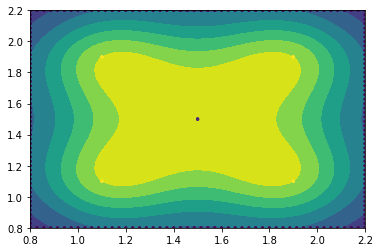

In [6]:
plt.contourf(xx, yy, surf)
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], s=5);
plt.xlim(0.8, 2.2)
plt.ylim(0.8, 2.2);

I've added smoothing parameter, but this will perform **approximation** of the surface instead of interpolation.

Use this snippet to make ipywidgets work in JupyterLab:

`jupyter labextension install @jupyter-widgets/jupyterlab-manager`

In [7]:
import ipywidgets

In [8]:
def f(sigma=.01):
    NUM_POINTS = 50
    surf = np.zeros((NUM_POINTS, NUM_POINTS))
    xx, yy = gen_grid(0, 3, 0, 3, NUM_POINTS)
    for i in range(NUM_POINTS):
        for j in range(NUM_POINTS):
            surf[i, j] = e.estimate(xx[i, j], yy[i, j], sigma=sigma)
    plt.contourf(xx, yy, surf)
    plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], s=8)
    plt.xlim(0.8, 2.2)
    plt.ylim(0.8, 2.2);

In [25]:
sigma_slider = ipywidgets.FloatLogSlider(base=10, min=-2, max=0, ax=.001, value=0.01)

In [26]:
ipywidgets.interact(f, sigma=sigma_slider);

interactive(children=(FloatLogSlider(value=0.01, description='sigma', max=0.0, min=-2.0), Output()), _dom_clas…